In [135]:
library(ggplot2)
library(dplyr)
library(plot3D)
library(pracma)
library(latex2exp)

Warning message:
"pakiet 'latex2exp' został zbudowany w wersji R 4.2.2"


# Zmiany pogody uwzględnione w modelu

In [2]:
data_wind <- read.csv('wind_clouds.csv')
colnames(data_wind) <- c('time','clouds','sun', 'speed', 'direction')

## Funkcje generujące koncentrację zanieczyszczeń

In [3]:
find_category <- function(speed, sun, clouds){
    if(speed<2){
        if(sun>=280) p<-'A'
        else if(sun>=120) p<-'B'
        else if(clouds>=50) p<-'E'
        else p<-'F'
    }
    else if(speed<3){
        if(sun>=479) p<-'A'
        else if(sun>=280) p<-'B'
        else if(sun>=120) p<-'C'
        else if(clouds>=50) p<-'E'
        else p<-'F'
    }
    else if(speed<5){
        if(sun>=280) p<-'B'
        else if(sun>=120) p<-'C'
        else if(clouds>=50) p<-'D'
        else p<-'E'
    }
    else if(speed<6){
        if(sun>=280) p<-'C'
        else p<-'D'
    }
    else{
        if(sun>=479) p<-'C'
        else p<-'D'
    }
    return(p)
}

In [4]:
find_p <- function(category){
    if(category=='A'|category=='B') p <- .15
    else if(category=='C') p <- .2
    else if(category=='D') p <- .25
    else p <- .3
    return(p)
}

In [5]:
find_a_b <- function(x,category){
    if(category=='A'){
        if(x<.1) pars <- c(122.800,0.94470)
        else if(x<.15) pars <- c(158.080,1.05420)
        else if(x<.2) pars <- c(170.220,1.09320)
        else if(x<.25) pars <- c(179.520,1.12620)
        else if(x<.3) pars <- c(217.410,1.26440)
        else if(x<.4) pars <- c(258.890,1.40940)
        else if(x<.5) pars <- c(346.750,1.72830)
        else if(x<=3.11) pars <- c(453.850,2.11660)
        else pars <- c(5000,1)
    }
    else if(category=='B'){
        if(x<.2) pars <- c(90.673,0.93198)
        else if(x<.4) pars <- c(98.483,0.98332)
        else pars <- c(109.300,1.09710)
    }
    else if(category=='C') pars <- c(61.141,0.91465)
    else if(category=='D'){
        if(x<.3) pars <- c(34.459,0.86974)
        else if(x<1) pars <- c(32.093,0.81066)
        else if(x<3) pars <- c(32.093,0.64403)
        else if(x<10) pars <- c(33.504,0.60486)
        else if(x<30) pars <- c(36.650,0.56589)
        else pars <- c(44.053,0.51179)
    }
    else if(category=='E'){
        if(x<.1) pars <- c(24.260,0.83660)
        else if(x<.3) pars <- c(23.331,0.81956)
        else if(x<1) pars <- c(21.628,0.75660)
        else if(x<2) pars <- c(21.628,0.63077)
        else if(x<4) pars <- c(22.534,0.57154)
        else if(x<10) pars <- c(24.703,0.50527)
        else if(x<20) pars <- c(26.970,0.46713)
        else if(x<40) pars <- c(35.420,0.37615)
        else pars <- c(47.618,0.29592)
    }
    else{
        if(x<.2) pars <- c(15.209,0.81558)
        else if(x<.7) pars <- c(14.457,0.78407)
        else if(x<1) pars <- c(13.953,0.68465)
        else if(x<2) pars <- c(13.953,0.63227)
        else if(x<3) pars <- c(14.823,0.54503)
        else if(x<7) pars <- c(16.187,0.46490)
        else if(x<15) pars <- c(17.836,0.41507)
        else if(x<30) pars <- c(22.651,0.32681)
        else if(x<60) pars <- c(27.074,0.27436)
        else pars <- c(34.219,0.21716)
    }
    return(pars)
}

In [6]:
find_theta <- function(x,category){
    if(category=='A') pars <- c(24.1670,2.5334)
    else if(category=='B') pars <- c(18.3330,1.8096)
    else if(category=='C') pars <- c(12.5000,1.0857)
    else if(category=='D') pars <- c(8.3330,0.72382)
    else if(category=='E') pars <- c(6.2500,0.54287)
    else pars <- c(4.1667,0.36191)
    theta <- .017453293*(pars[1]-pars[2]*log(x))
    return(theta)
}

In [7]:
get_concentration <- function(Q,u,h,dy,dz,y,z){
    result = Q/(2*pi*u*dy*dz)*(exp(-(z-h)^2/(2*dz^2))+exp(-(z-h)^2/(2*dz^2)))*exp(-y^2/(2*dy^2))
    return(result)
}

In [8]:
gaussian_plume_xyh <- function(row,y,z, h=10, x_vec=seq(.1,10,.01), Q=0.01){
    category <- find_category(row$speed,row$sun,row$clouds)
    p <- find_p(category)
    cs <- c()
    for(x in x_vec){
        if(x<=0){
            cs <- c(cs,0)
            next
        }
        a_b <- find_a_b(x,category)
        theta <- find_theta(x,category)
        u <- row$speed*(h/10)^p
        a <- a_b[1]
        b <- a_b[2]
        dz <- a*x**b
        if(dz>5000) dz<-5000
        dy <- 465.11628*x*tan(theta)
        c1 <- get_concentration(Q,u,h,dy,dz,y,z)
        cs <- c(cs,c1)
    }
    return(cs)
}

In [9]:
pollution_average2 <- function(en,r,c){
    new_matrix <- matrix(data=0, nrow=r, ncol=c)
    new_matrix[1,1] = mean(c(en[1,1],en[2,1],en[1,2],0,0))
    new_matrix[1,c] = mean(c(en[1,c],en[2,c],en[1,(c-1)],0,0))
    new_matrix[r,1] = mean(c(en[r,1],en[(r-1),1],en[r,2],0,0))
    new_matrix[r,c] = mean(c(en[r,c],en[(r-1),c],en[r,(c-1)],0,0))
    for(i in 2:(r-1)) new_matrix[i,1] = mean(c(en[i,1],en[i-1,1],en[i+1,1],en[i,2],0))
    for(i in 2:(r-1)) new_matrix[i,c] = mean(c(en[i,c],en[i-1,c],en[i+1,c],en[i,(c-1)],0))
    for(j in 2:(c-1)) new_matrix[1,j] = mean(c(en[1,j-1],en[1,j],en[1,j+1],en[2,c],0))
    for(j in 2:(c-1)) new_matrix[r,j] = mean(c(en[r,j-1],en[r,j],en[r,j+1],en[(r-1),j],0))
    for(i in 2:(r-1)){
        for(j in 2:(c-1)) new_matrix[i,j] = mean(c(en[i,j],en[i-1,j],en[i+1,j],en[i,j-1],en[i,j+1]))
    }
    return(new_matrix)
}

## Funkcja generująca pliki z odpowiednimi powierzchniami

In [10]:
gen_in_time <- function(t, sx=seq(0.01,1,0.01), sy=seq(-10,10,.01), z=2){
    for(i in t){
        y <- c()
        cond <- c()
        nx <- length(sx)
        ny <- length(sy)
        nt <- nx*ny
        base <- data_wind[i,]
        for(j in sy){
            y <- c(y,rep(j,nx))
            cond <- c(cond,gaussian_plume_xyh(base,j,z,h=10,x_vec=sx))
        }
        df <- data.frame(y,rep(sx,ny),cond)
        colnames(df) <- c('y','x','cs')
        write.csv(df,paste('./2D/surface',i, '.csv'))
    }
    return(NULL)
}

# Zanieczyszczenie w zależności od prędkości wiatru

### prędkość wiatru: $\left[0,7\right]\frac{m}{s}$, zachmurzenie: $20\%$, nasłonecznienie: $100\frac{W}{m^2}$

### $x\in\left[0.01,2.01\right]km,\,\,y\in\left[-10,10\right]m,\,\,z=1.7m,\,\, h=10m$

In [14]:
check_speed <- data.frame(id=1:8,clouds=rep(20,8),sun=rep(100,8),speed=0:7, direction=rep(0,8))

In [68]:
sx <- seq(0.01,2.01,0.01)
sy <- seq(-10,10,.01)
nx <- length(sx)
ny <- length(sy)
for(j in 1:8){
    y_s1 <- c()
    cond_s1 <- c()
    for(i in sy){
        y_s1 <- c(y_s1,rep(i,nx))
        cond_s1 <- c(cond_s1,gaussian_plume_xyh(check_speed[j,],i,1.7,h=10,x_vec=sx))
    }
    temp <- data.frame(y_s1,rep(sx,ny),cond_s1)
    colnames(temp) <- c('y','x','cs')
    write.csv(temp,paste('./speed/speed',j, '.csv'))
}

In [122]:
speed2 <- read.csv('./speed/speed 2 .csv')[,2:4]
speed3 <- read.csv('./speed/speed 3 .csv')[,2:4]
speed4 <- read.csv('./speed/speed 4 .csv')[,2:4]
speed5 <- read.csv('./speed/speed 5 .csv')[,2:4]
speed6 <- read.csv('./speed/speed 6 .csv')[,2:4]
speed7 <- read.csv('./speed/speed 7 .csv')[,2:4]
speed8 <- read.csv('./speed/speed 8 .csv')[,2:4]

Saving 10 x 6.67 in image


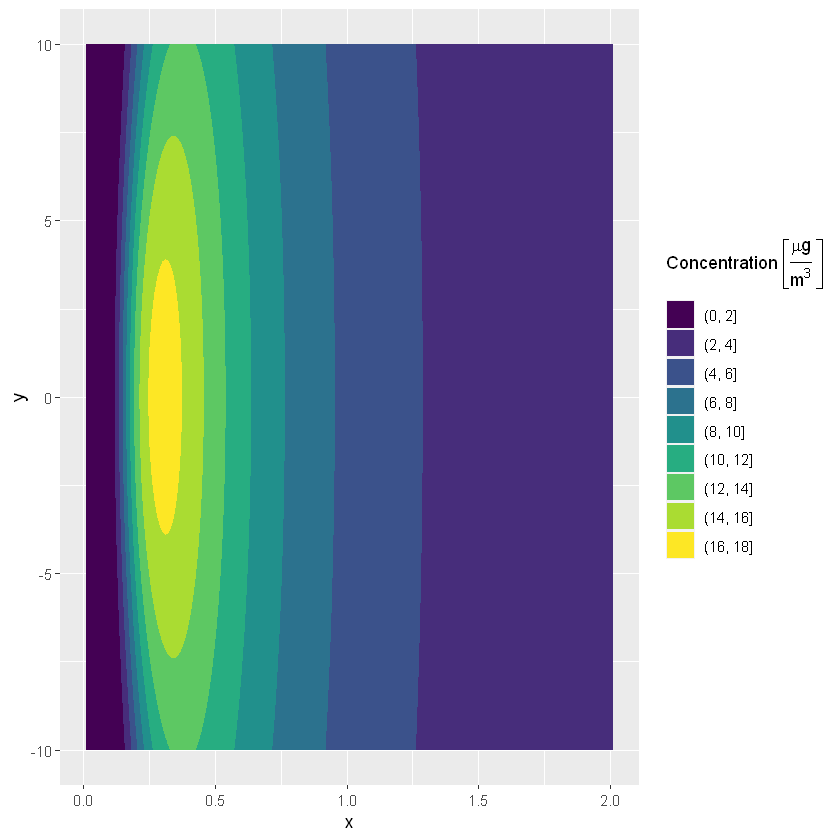

In [137]:
speed2_plot <- ggplot(speed2, aes(x,y,z=cs*10^6))+geom_contour_filled(breaks=seq(0,18,2))+
    scale_fill_viridis_d(drop = FALSE)+
    guides(fill=guide_legend(title=TeX("Concentration $\\left[\\frac{\\mu g}{m^3}\\right]$")))
speed2_plot
#ggsave('./plots/speed/speed2_plot.jpg', speed2_plot, 'jpg', width=10)

Saving 10 x 6.67 in image


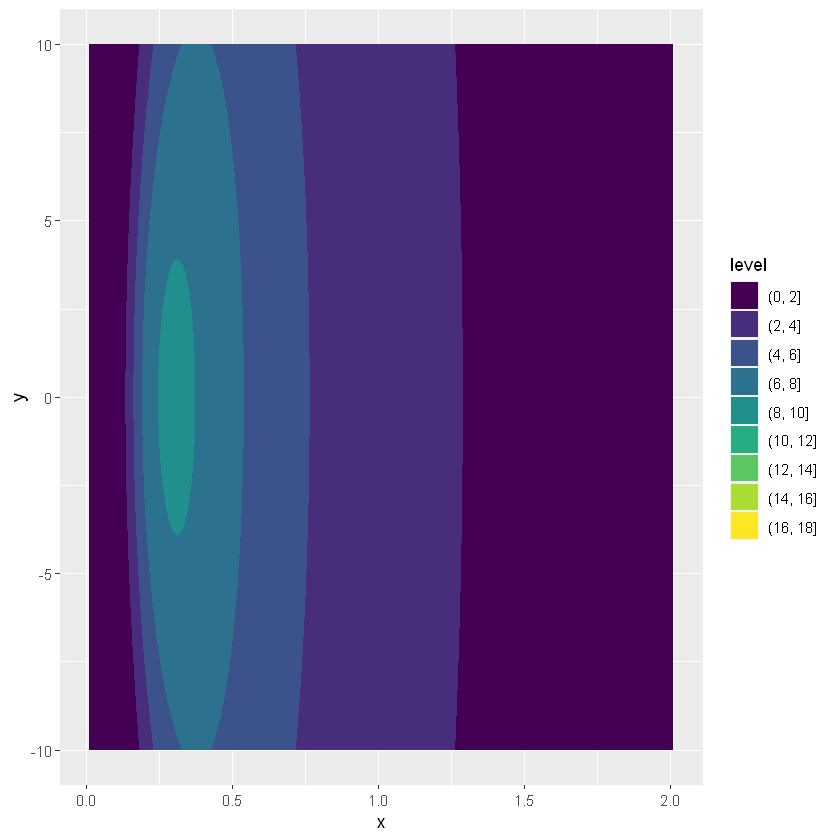

In [138]:
speed3_plot <- ggplot(speed3, aes(x,y,z=cs*10^6))+geom_contour_filled(breaks=seq(0,18,2))+ 
    scale_fill_viridis_d(drop = FALSE)+
    guides(fill=guide_legend(title=TeX("Concentration $\\left[\\frac{\\mu g}{m^3}\\right]$")))
speed3_plot
#ggsave('./plots/speed/speed3_plot.jpg', speed3_plot, 'jpg', width=10)

Saving 10 x 6.67 in image


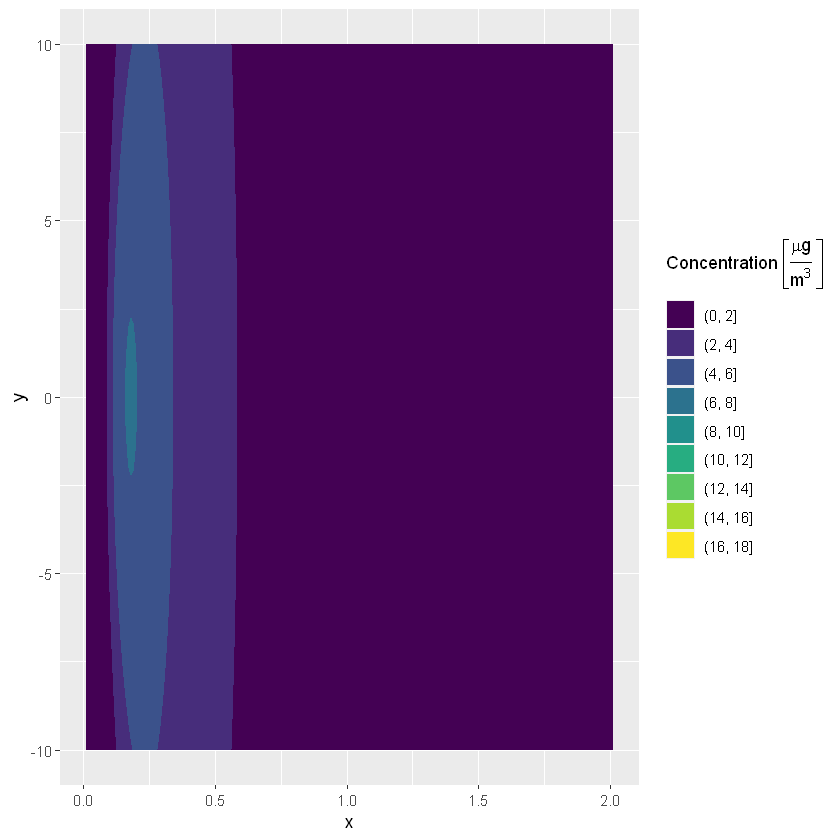

In [139]:
speed4_plot <- ggplot(speed4, aes(x,y,z=cs*10^6))+geom_contour_filled(breaks=seq(0,18,2))+ 
    scale_fill_viridis_d(drop = FALSE)+
    guides(fill=guide_legend(title=TeX("Concentration $\\left[\\frac{\\mu g}{m^3}\\right]$")))
speed4_plot
#ggsave('./plots/speed/speed4_plot.jpg', speed4_plot, 'jpg', width=10)

Saving 10 x 6.67 in image


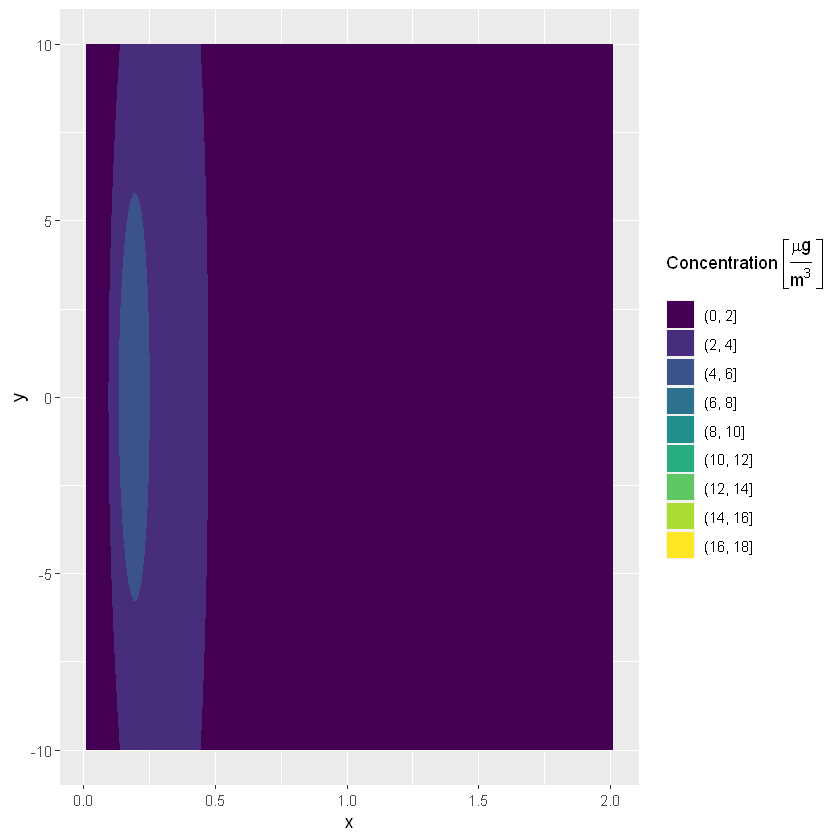

In [141]:
speed5_plot <- ggplot(speed5, aes(x,y,z=cs*10^6))+geom_contour_filled(breaks=seq(0,18,2))+ 
    scale_fill_viridis_d(drop = FALSE)+
    guides(fill=guide_legend(title=TeX("Concentration $\\left[\\frac{\\mu g}{m^3}\\right]$")))
speed5_plot
#ggsave('./plots/speed/speed5_plot.jpg', speed5_plot, 'jpg', width=10)

Saving 10 x 6.67 in image


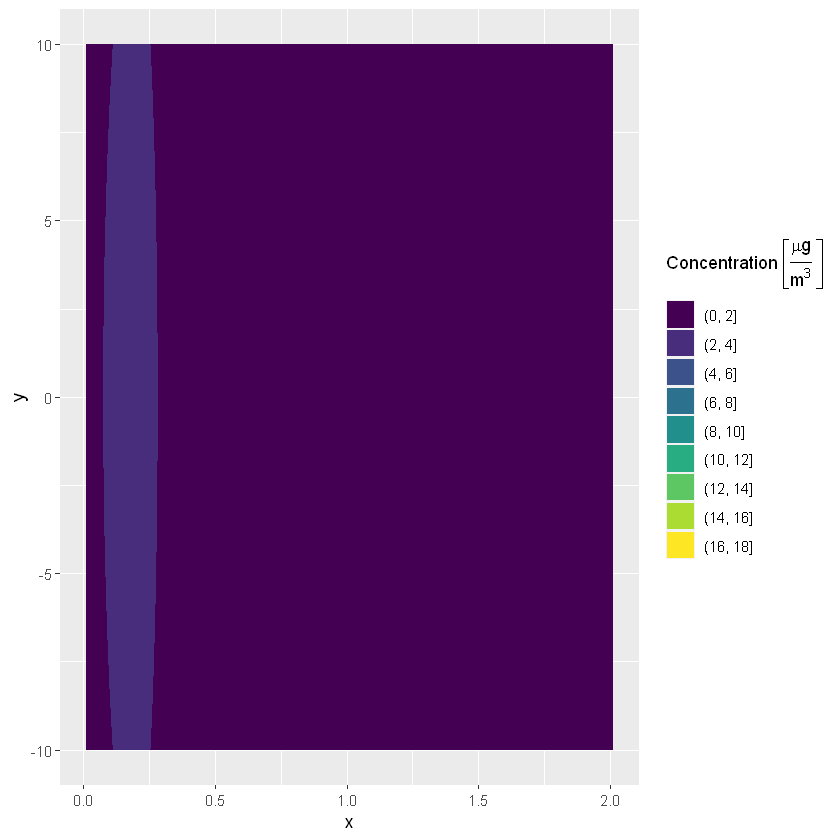

In [142]:
speed6_plot <- ggplot(speed6, aes(x,y,z=cs*10^6))+geom_contour_filled(breaks=seq(0,18,2))+ 
    scale_fill_viridis_d(drop = FALSE)+
    guides(fill=guide_legend(title=TeX("Concentration $\\left[\\frac{\\mu g}{m^3}\\right]$")))
speed6_plot
#ggsave('./plots/speed/speed6_plot.jpg', speed6_plot, 'jpg', width=10)

Saving 10 x 6.67 in image


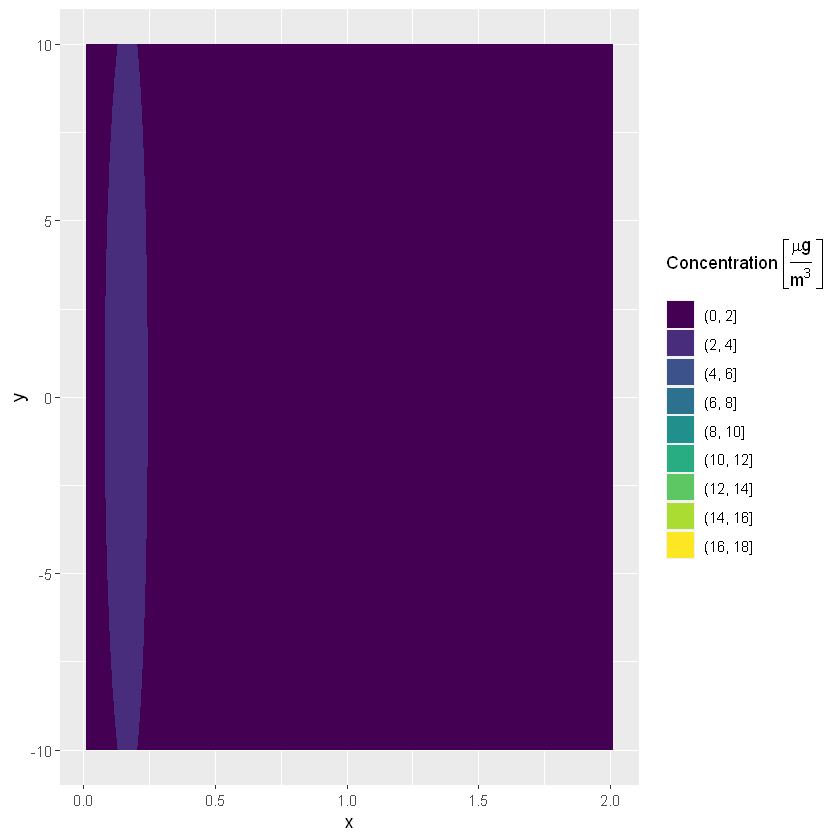

In [143]:
speed7_plot <- ggplot(speed7, aes(x,y,z=cs*10^6))+geom_contour_filled(breaks=seq(0,18,2))+ 
    scale_fill_viridis_d(drop = FALSE)+
    guides(fill=guide_legend(title=TeX("Concentration $\\left[\\frac{\\mu g}{m^3}\\right]$")))
speed7_plot
#ggsave('./plots/speed/speed7_plot.jpg', speed7_plot, 'jpg', width=10)

Saving 10 x 6.67 in image


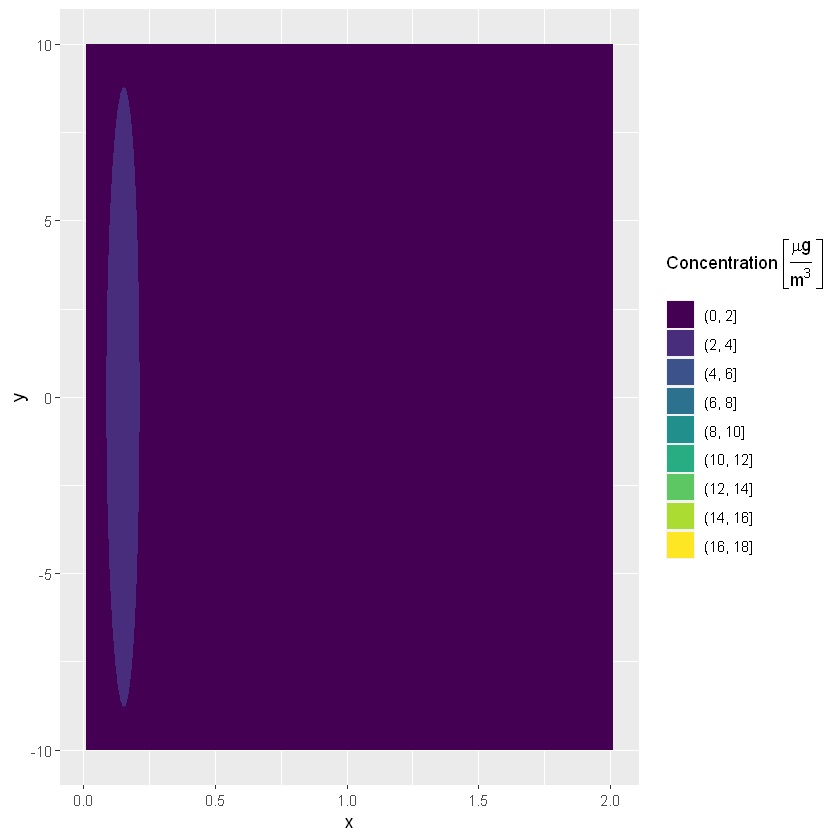

In [144]:
speed8_plot <- ggplot(speed8, aes(x,y,z=cs*10^6))+geom_contour_filled(breaks=seq(0,18,2))+ 
    scale_fill_viridis_d(drop = FALSE)+
    guides(fill=guide_legend(title=TeX("Concentration $\\left[\\frac{\\mu g}{m^3}\\right]$")))
speed8_plot
#ggsave('./plots/speed/speed8_plot.jpg', speed8_plot, 'jpg', width=10)

### Maksymalne koncentracje dla różnych prędkości

In [145]:
css_speed <- data.frame(speed2$cs, speed3$cs, speed4$cs, speed5$cs, speed6$cs, speed7$cs, speed8$cs)
css_speed_max <- sapply(css_speed*10^6, max)

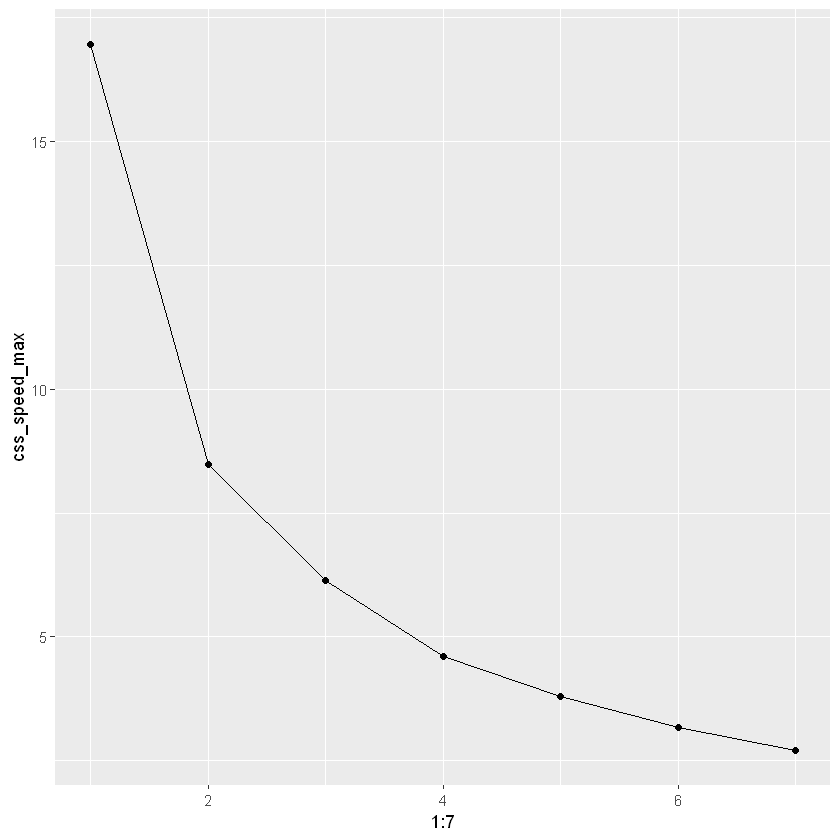

In [146]:
ggplot(mapping=aes(1:7,css_speed_max))+geom_point()+geom_line()

In [152]:
check_speed2 <- data.frame(id=1:8,clouds=rep(20,8),sun=rep(400,8),speed=0:7, direction=rep(0,8))

In [76]:
sx <- seq(0.01,2.01,0.01)
sy <- seq(-10,10,.01)
nx <- length(sx)
ny <- length(sy)
for(j in 2:8){
    y_s1 <- c()
    cond_s1 <- c()
    for(i in sy){
        y_s1 <- c(y_s1,rep(i,nx))
        cond_s1 <- c(cond_s1,gaussian_plume_xyh(check_speed2[j,],i,1.7,h=10,x_vec=sx))
    }
    temp <- data.frame(y_s1,rep(sx,ny),cond_s1)
    colnames(temp) <- c('y','x','cs')
    write.csv(temp,paste('./speed/speed2',j, '.csv'))
}

In [148]:
speed21 <- read.csv('./speed/speed2 1 .csv')[,2:4]
speed22 <- read.csv('./speed/speed2 2 .csv')[,2:4]
speed23 <- read.csv('./speed/speed2 3 .csv')[,2:4]
speed24 <- read.csv('./speed/speed2 4 .csv')[,2:4]
speed25 <- read.csv('./speed/speed2 5 .csv')[,2:4]
speed26 <- read.csv('./speed/speed2 6 .csv')[,2:4]
speed27 <- read.csv('./speed/speed2 7 .csv')[,2:4]
speed28 <- read.csv('./speed/speed2 8 .csv')[,2:4]

In [149]:
css_speed2 <- data.frame(speed22$cs, speed23$cs, speed24$cs, speed25$cs, speed26$cs, speed27$cs, speed28$cs)
css_speed2_max <- sapply(css_speed2*10^6, max)

In [ ]:
check_speed3 <- data.frame(id=1:8,clouds=rep(20,8),sun=rep(600,8),speed=0:7, direction=rep(0,8))
sx <- seq(0.01,2.01,0.01)
sy <- seq(-10,10,.01)
nx <- length(sx)
ny <- length(sy)
for(j in 2:8){
    y_s1 <- c()
    cond_s1 <- c()
    for(i in sy){
        y_s1 <- c(y_s1,rep(i,nx))
        cond_s1 <- c(cond_s1,gaussian_plume_xyh(check_speed3[j,],i,1.7,h=10,x_vec=sx))
    }
    temp <- data.frame(y_s1,rep(sx,ny),cond_s1)
    colnames(temp) <- c('y','x','cs')
    write.csv(temp,paste('./speed/speed3',j, '.csv'))
}

In [ ]:
speed31 <- read.csv('./speed/speed3 1 .csv')[,2:4]
speed32 <- read.csv('./speed/speed3 2 .csv')[,2:4]
speed33 <- read.csv('./speed/speed3 3 .csv')[,2:4]
speed34 <- read.csv('./speed/speed3 4 .csv')[,2:4]
speed35 <- read.csv('./speed/speed3 5 .csv')[,2:4]
speed36 <- read.csv('./speed/speed3 6 .csv')[,2:4]
speed37 <- read.csv('./speed/speed3 7 .csv')[,2:4]
speed38 <- read.csv('./speed/speed3 8 .csv')[,2:4]

In [ ]:
css_speed3 <- data.frame(speed32$cs, speed33$cs, speed34$cs, speed35$cs, speed36$cs, speed37$cs, speed38$cs)
css_speed3_max <- sapply(css_speed3*10^6, max)

In [167]:
check_speed4 <- data.frame(id=1:8,clouds=rep(100,8),sun=rep(100,8),speed=0:7, direction=rep(0,8))
sx <- seq(0.01,2.01,0.01)
sy <- seq(-10,10,.01)
nx <- length(sx)
ny <- length(sy)
for(j in 2:8){
    y_s1 <- c()
    cond_s1 <- c()
    for(i in sy){
        y_s1 <- c(y_s1,rep(i,nx))
        cond_s1 <- c(cond_s1,gaussian_plume_xyh(check_speed4[j,],i,1.7,h=10,x_vec=sx))
    }
    temp <- data.frame(y_s1,rep(sx,ny),cond_s1)
    colnames(temp) <- c('y','x','cs')
    write.csv(temp,paste('./speed/speed4',j, '.csv'))
}

In [168]:
speed42 <- read.csv('./speed/speed4 2 .csv')[,2:4]
speed43 <- read.csv('./speed/speed4 3 .csv')[,2:4]
speed44 <- read.csv('./speed/speed4 4 .csv')[,2:4]
speed45 <- read.csv('./speed/speed4 5 .csv')[,2:4]
speed46 <- read.csv('./speed/speed4 6 .csv')[,2:4]
speed47 <- read.csv('./speed/speed4 7 .csv')[,2:4]
speed48 <- read.csv('./speed/speed4 8 .csv')[,2:4]

In [169]:
css_speed4 <- data.frame(speed42$cs, speed43$cs, speed44$cs, speed45$cs, speed46$cs, speed47$cs, speed48$cs)
css_speed4_max <- sapply(css_speed4*10^6, max)

Saving 10 x 6.67 in image


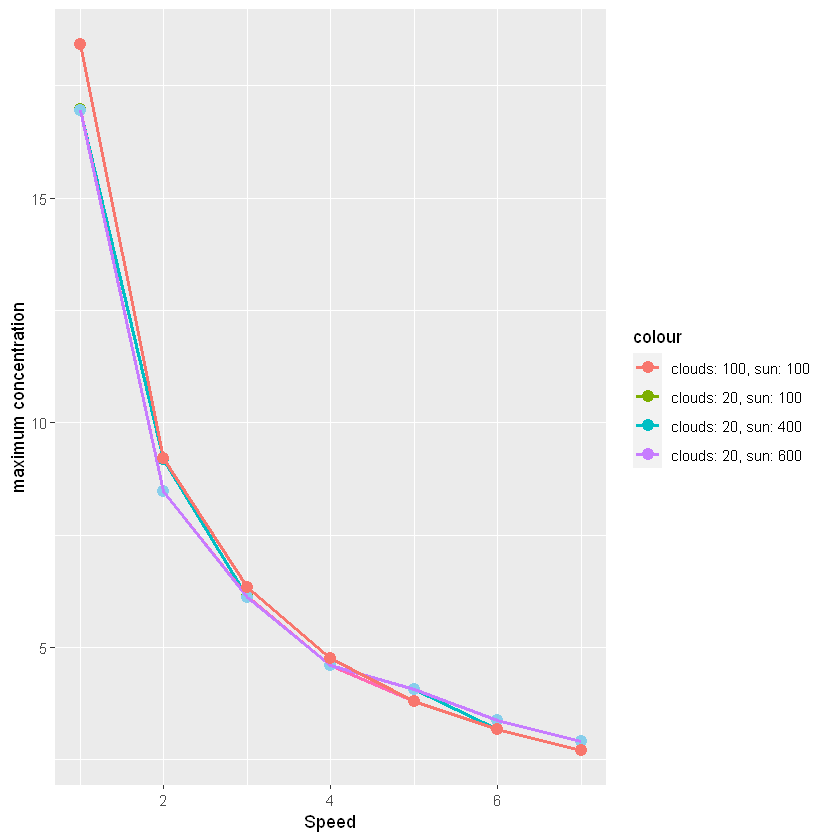

In [173]:
speed_max_conc_plot <- ggplot(mapping=aes(1:7,css_speed2_max))+geom_point(aes(col='clouds: 20, sun: 400'),cex=3)+
    geom_line(aes(col='clouds: 20, sun: 400'), linewidth=1)+
    geom_point(aes(1:7,css_speed_max, col='clouds: 20, sun: 100'), cex=3)+
    geom_line(aes(1:7,css_speed_max, col='clouds: 20, sun: 100'),col='hotpink',linewidth=1)+
    geom_point(aes(1:7,css_speed3_max, col='clouds: 20, sun: 600'),col='skyblue',cex=3)+
    geom_line(aes(1:7,css_speed3_max, col='clouds: 20, sun: 600'),linewidth=1)+
    geom_point(aes(1:7,css_speed4_max, col='clouds: 100, sun: 100'),cex=3)+
    geom_line(aes(1:7,css_speed4_max, col='clouds: 100, sun: 100'),linewidth=1)+
    xlab('Speed')+ylab('maximum concentration')+
    guides(fill=guide_legend(title='Parameters'))
speed_max_conc_plot
#ggsave('./plots/speed/speed_max_conc_plot.jpg', speed_max_conc_plot, 'jpg', width=10)

# Zanieczyszczenie w zależności od zachmurzenia

### prędkość wiatru: $3\frac{m}{s}$, zachmurzenie: $\left[0,100\right]\%$, nasłonecznienie: $100\frac{W}{m^2}$

In [42]:
check_clouds <- data.frame(id=1:10,clouds=linspace(0,100,10),sun=rep(100,10),speed=rep(3,10), direction=rep(0,10))

In [43]:
sx <- seq(0.01,2.01,0.01)
sy <- seq(-10,10,.01)
nx <- length(sx)
ny <- length(sy)
for(j in 1:10){
    y_c1 <- c()
    cond_c1 <- c()
    for(i in sy){
        y_c1 <- c(y_c1,rep(i,nx))
        cond_c1 <- c(cond_c1,gaussian_plume_xyh(check_clouds[j,],i,1.7,h=10,x_vec=sx))
    }
    temp <- data.frame(y_c1,rep(sx,ny),cond_c1)
    colnames(temp) <- c('y','x','cs')
    write.csv(temp,paste('./clouds/clouds',j, '.csv'))
}

In [50]:
clouds1 <- read.csv('./clouds/clouds 1 .csv')[,2:4]
clouds2 <- read.csv('./clouds/clouds 2 .csv')[,2:4]
clouds3 <- read.csv('./clouds/clouds 3 .csv')[,2:4]
clouds4 <- read.csv('./clouds/clouds 4 .csv')[,2:4]
clouds5 <- read.csv('./clouds/clouds 5 .csv')[,2:4]
clouds6 <- read.csv('./clouds/clouds 6 .csv')[,2:4]
clouds7 <- read.csv('./clouds/clouds 7 .csv')[,2:4]
clouds8 <- read.csv('./clouds/clouds 8 .csv')[,2:4]
clouds9 <- read.csv('./clouds/clouds 9 .csv')[,2:4]
clouds10 <- read.csv('./clouds/clouds 10 .csv')[,2:4]

In [82]:
css_clouds <- data.frame(clouds2$cs, clouds3$cs, clouds4$cs, clouds5$cs, clouds6$cs, clouds7$cs, clouds8$cs, clouds9$cs, clouds10$cs)
css_clouds_max <- sapply(css_clouds*10^6, max)

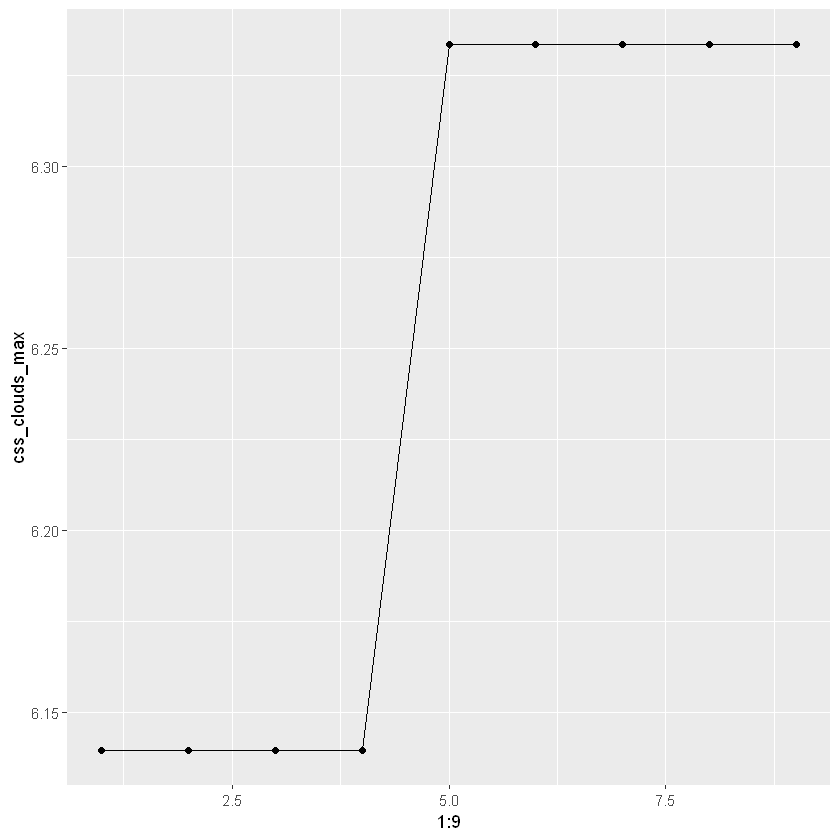

In [84]:
ggplot(mapping=aes(1:9,css_clouds_max))+geom_point()+geom_line()

In [98]:
check_clouds_max <- data.frame(id=1:20,clouds=linspace(0,100,20),sun=rep(100,20),speed=rep(3,20), direction=rep(0,20))

In [99]:
max_clouds <- c()
sx <- seq(0.01,2.01,0.01)
sy <- seq(-10,10,.01)
nx <- length(sx)
ny <- length(sy)
for(j in 1:20){
    temp <- c()
    for(i in sy) temp <- max(gaussian_plume_xyh(check_clouds_max[j,],i,1.7,h=10,x_vec=sx))
    max_clouds <- c(max_clouds,max(temp))
}

In [100]:
df_max_clouds <- data.frame(clouds=linspace(0,100,20), max_val=max_clouds*10^6)

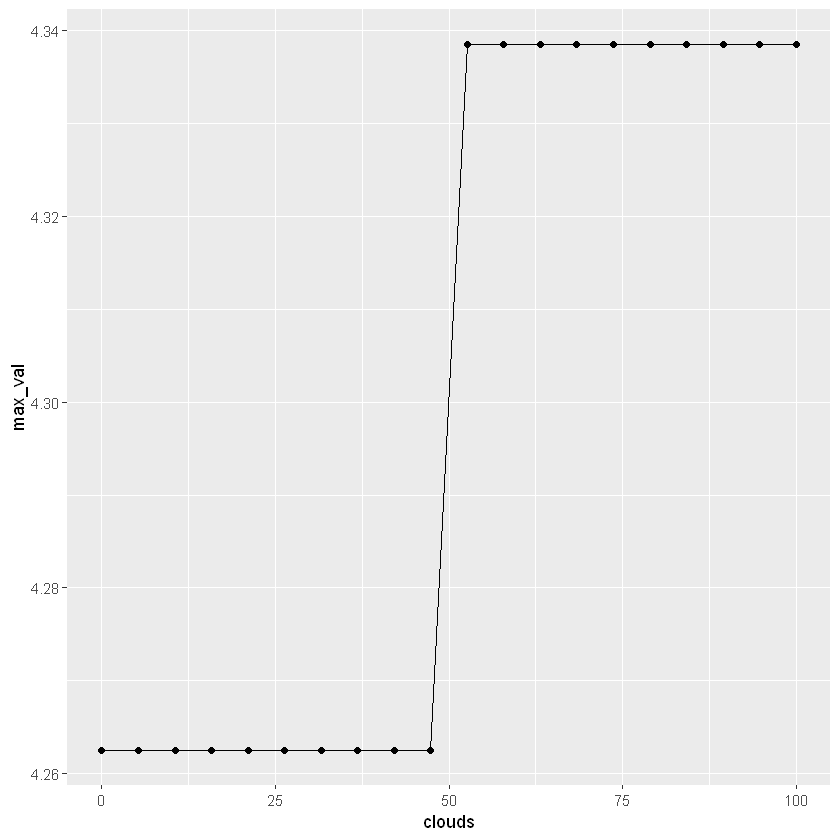

In [101]:
ggplot(df_max_clouds, aes(clouds,max_val))+geom_point()+geom_line()

# Zanieczyszczenie w zależności od wysokości słońca/nasłonecznienia

### prędkość wiatru: $3\frac{m}{s}$, zachmurzenie: $20\%$, nasłonecznienie: $\left[0,719\right]\frac{W}{m^2}$

In [46]:
check_sun <- data.frame(id=1:15,clouds=rep(20,15),sun=linspace(0,719,15),speed=rep(3,15), direction=rep(0,15))

In [47]:
sx <- seq(0.01,2.01,0.01)
sy <- seq(-10,10,.01)
nx <- length(sx)
ny <- length(sy)
for(j in 1:15){
    y_sun1 <- c()
    cond_sun1 <- c()
    for(i in sy){
        y_sun1 <- c(y_sun1,rep(i,nx))
        cond_sun1 <- c(cond_sun1,gaussian_plume_xyh(check_sun[j,],i,1.7,h=10,x_vec=sx))
    }
    temp <- data.frame(y_sun1,rep(sx,ny),cond_sun1)
    colnames(temp) <- c('y','x','cs')
    write.csv(temp,paste('./sun/sun',j, '.csv'))
}

In [174]:
sun1 <- read.csv('./sun/sun 1 .csv')[,2:4]
sun2 <- read.csv('./sun/sun 2 .csv')[,2:4]
sun3 <- read.csv('./sun/sun 3 .csv')[,2:4]
sun4 <- read.csv('./sun/sun 4 .csv')[,2:4]
sun5 <- read.csv('./sun/sun 5 .csv')[,2:4]
sun6 <- read.csv('./sun/sun 6 .csv')[,2:4]
sun7 <- read.csv('./sun/sun 7 .csv')[,2:4]
sun8 <- read.csv('./sun/sun 8 .csv')[,2:4]
sun9 <- read.csv('./sun/sun 9 .csv')[,2:4]
sun10 <- read.csv('./sun/sun 10 .csv')[,2:4]
sun11 <- read.csv('./sun/sun 11 .csv')[,2:4]
sun12 <- read.csv('./sun/sun 12 .csv')[,2:4]
sun13 <- read.csv('./sun/sun 13 .csv')[,2:4]
sun14 <- read.csv('./sun/sun 14 .csv')[,2:4]
sun15 <- read.csv('./sun/sun 15 .csv')[,2:4]

In [175]:
css_sun <- data.frame(sun1$cs, sun2$cs, sun3$cs, sun4$cs, sun5$cs, 
                        sun6$cs, sun7$cs, sun8$cs, sun9$cs, sun10$cs, 
                        sun11$cs, sun12$cs, sun13$cs, sun14$cs, sun15$cs)
css_sun_max <- sapply(css_sun*10^6, max)

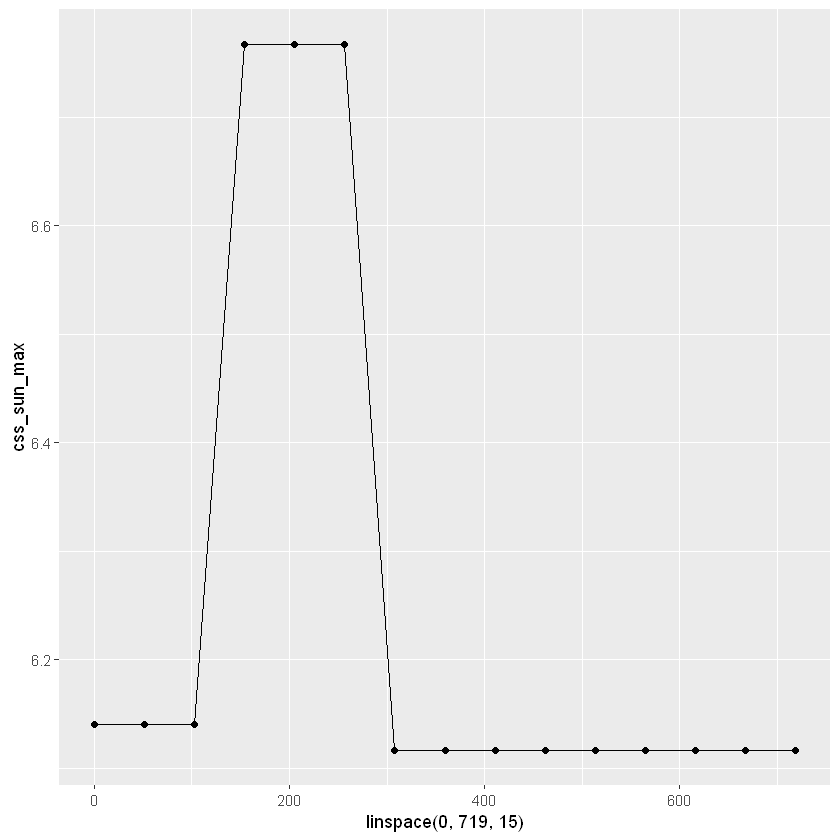

In [177]:
ggplot(mapping=aes(linspace(0,719,15),css_sun_max))+geom_point()+geom_line()

## Maksymalne koncentracje dla różnych wartości zachmurzenia i nasłonecznienia

### prędkość wiatru: $3\frac{m}{s}$, zachmurzenie: $\left[0,100\right]\%$, nasłonecznienie: $\left[0,719\right]\frac{W}{m^2}$

In [103]:
check_maxes <- data.frame(id=1:400,clouds=rep(linspace(0,100,20),20),
                          sun=rep(linspace(0,719,20), each=20),speed=rep(3,400), direction=rep(0,400))

In [104]:
maxes <- c()
sx <- seq(0.01,2.01,0.01)
sy <- seq(-10,10,.01)
nx <- length(sx)
ny <- length(sy)
for(j in 1:400){
    temp <- c()
    for(i in sy) temp <- max(gaussian_plume_xyh(check_maxes[j,],i,1.7,h=10,x_vec=sx))
    maxes <- c(maxes,max(temp))
}

In [115]:
df_maxes <- data.frame(clouds=rep(linspace(0,100,20),20), sun=rep(linspace(0,719,20),each=20), max_val=maxes*10^6)

Saving 10 x 6.67 in image


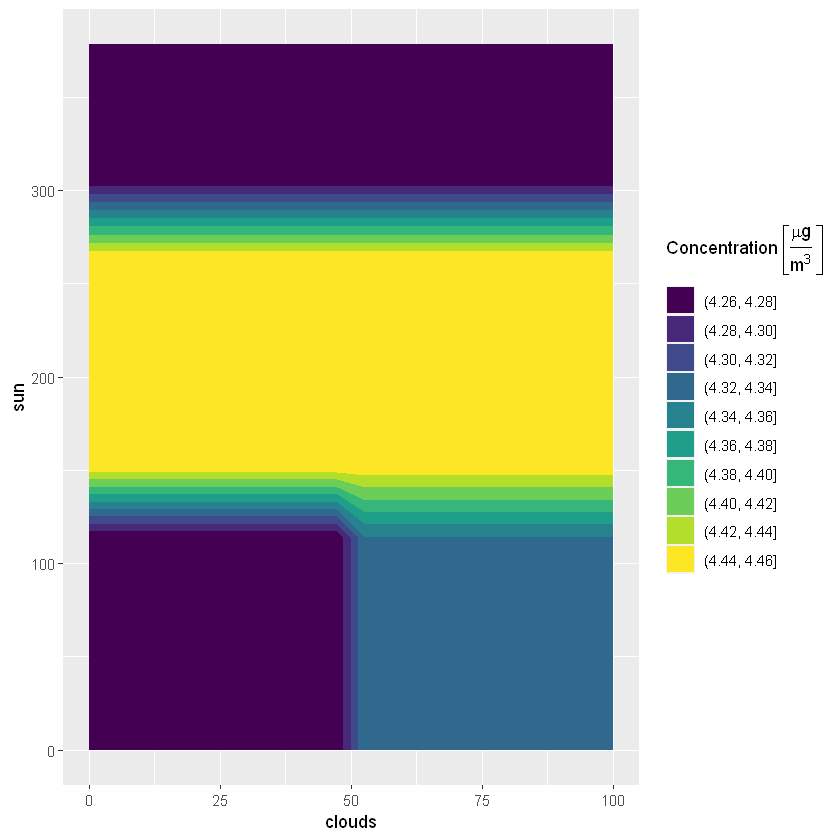

In [179]:
df_maxes_clouds_sun_plot <- ggplot(df_maxes[df_maxes$sun<400,], aes(clouds, sun, z=max_val))+geom_contour_filled()+
    guides(fill=guide_legend(title=TeX("Concentration $\\left[\\frac{\\mu g}{m^3}\\right]$")))
df_maxes_clouds_sun_plot
#ggsave('./plots/df_maxes_clouds_sun_plot.jpg', df_maxes_clouds_sun_plot, 'jpg', width=10)

## Maksymalne koncentracje dla różnych wartości zachmurzenia i prędkości wiatru

### prędkość wiatru: $\left[1,7\right]\frac{m}{s}$, zachmurzenie: $\left[0,100\right]\%$, nasłonecznienie: $100\frac{W}{m^2}$

In [112]:
check_maxes2 <- data.frame(id=1:140,clouds=rep(linspace(0,100,20),7),
                          sun=rep(100,140),speed=rep(1:7,each=20), direction=rep(0,140))

In [114]:
maxes2 <- c()
sx <- seq(0.01,2.01,0.01)
sy <- seq(-10,10,.01)
nx <- length(sx)
ny <- length(sy)
for(j in 1:140){
    temp <- c()
    for(i in sy) temp <- max(gaussian_plume_xyh(check_maxes2[j,],i,1.7,h=10,x_vec=sx))
    maxes2 <- c(maxes2,max(temp))
}

In [120]:
df_maxes2 <- data.frame(clouds=rep(linspace(0,100,20),7), speed=rep(1:7,each=20), max_val=maxes2*10^6)

Saving 10 x 6.67 in image


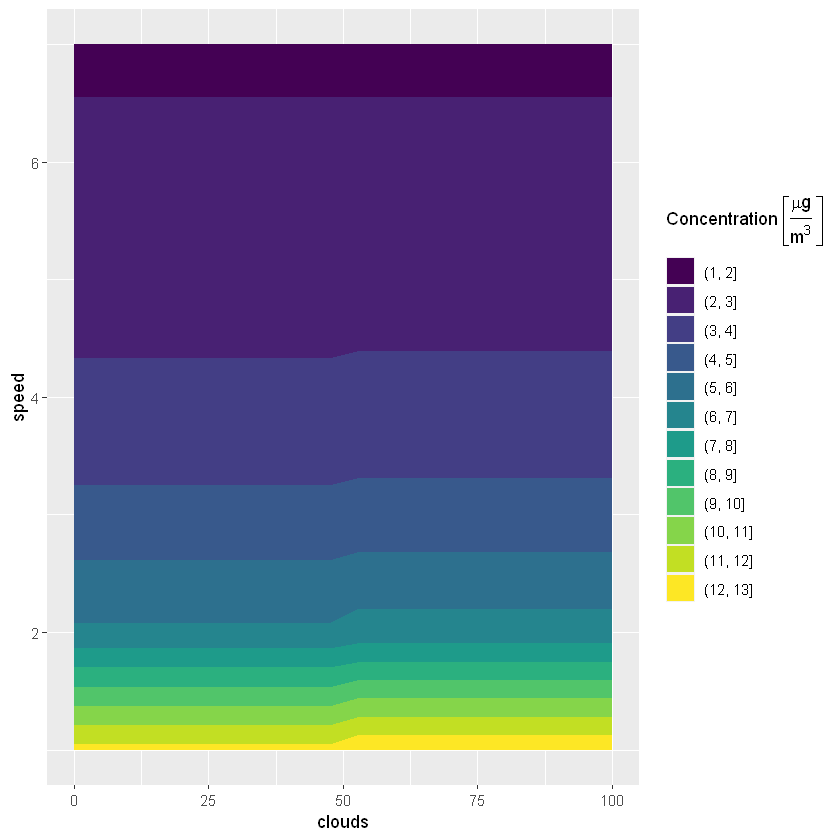

In [185]:
df_maxes_clouds_speed_plot <- ggplot(df_maxes2, aes(clouds, speed, z=max_val))+geom_contour_filled()+
    guides(fill=guide_legend(title=TeX("Concentration $\\left[\\frac{\\mu g}{m^3}\\right]$")))
df_maxes_clouds_speed_plot
#ggsave('./plots/df_maxes_clouds_speed_plot.jpg', df_maxes_clouds_speed_plot, 'jpg', width=10)